In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import time

Implémentation de l'environnement TicTacToe

In [4]:
class TicTacToe:
    def __init__(self):
        self.reset()

    def reset(self):
        self.board = [' '] * 9
        self.current_player = 'X' 
        return self.board.copy()

    def step(self, action):
        if self.board[action] != ' ':
            return self.board.copy(), -10, True, {"invalid": True}

        self.board[action] = self.current_player
        if self.check_win(self.current_player):
            return self.board.copy(), 1, True, {}

        if ' ' not in self.board:
            return self.board.copy(), 0, True, {}

        # adversaire random
        opponent_move = random.choice([i for i, v in enumerate(self.board) if v == ' '])
        self.board[opponent_move] = 'O'
        if self.check_win('O'):
            return self.board.copy(), -1, True, {}

        return self.board.copy(), 0, False, {}

    def check_win(self, player):
        wins = [(0,1,2), (3,4,5), (6,7,8), (0,3,6), (1,4,7), (2,5,8), (0,4,8), (2,4,6)]
        return any(all(self.board[i] == player for i in combo) for combo in wins)

    def render(self):
        for i in range(3):
            print(self.board[3*i:3*(i+1)])


Random

In [16]:
import random
class RandomAgent:
    def select_action(self, state):
        return random.choice([i for i, v in enumerate(state) if v == ' '])

    def learn(self, *args, **kwargs):
        pass

In [17]:
def train_agent(agent, env, episodes=1000):
    rewards = []
    lengths = []
    for ep in range(episodes):
        state = env.reset()
        done = False
        ep_reward = 0
        steps = 0
        while not done:
            action = agent.select_action(state)
            next_state, reward, done, info = env.step(action)
            agent.learn(state, action, reward, next_state, done)
            state = next_state
            ep_reward += reward
            steps += 1
        rewards.append(ep_reward)
        lengths.append(steps)
        if (ep + 1) % 100 == 0:
            print(f"Episode {ep+1}/{episodes} - Moyenne des 100 derniers rewards : {np.mean(rewards[-100:]):.3f}")
    return rewards, lengths

def evaluate_agent(agent, env, episodes=100):
    rewards = []
    lengths = []
    action_times = []
    for _ in range(episodes):
        state = env.reset()
        done = False
        ep_reward = 0
        steps = 0
        while not done:
            start = time.time()
            action = agent.select_action(state)
            action_times.append(time.time() - start)
            state, reward, done, info = env.step(action)
            ep_reward += reward
            steps += 1
        rewards.append(ep_reward)
        lengths.append(steps)
    return {
        "score_moyen": np.mean(rewards),
        "longueur_moyenne": np.mean(lengths),
        "temps_moyen_action": np.mean(action_times) * 1000  # en ms
    }

 Entraînement de l'agent Random...
Episode 100/1000 - Moyenne des 100 derniers rewards : 0.520
Episode 200/1000 - Moyenne des 100 derniers rewards : 0.210
Episode 300/1000 - Moyenne des 100 derniers rewards : 0.290
Episode 400/1000 - Moyenne des 100 derniers rewards : 0.300
Episode 500/1000 - Moyenne des 100 derniers rewards : 0.340
Episode 600/1000 - Moyenne des 100 derniers rewards : 0.360
Episode 700/1000 - Moyenne des 100 derniers rewards : 0.330
Episode 800/1000 - Moyenne des 100 derniers rewards : 0.240
Episode 900/1000 - Moyenne des 100 derniers rewards : 0.400
Episode 1000/1000 - Moyenne des 100 derniers rewards : 0.380

 Graphique des récompenses


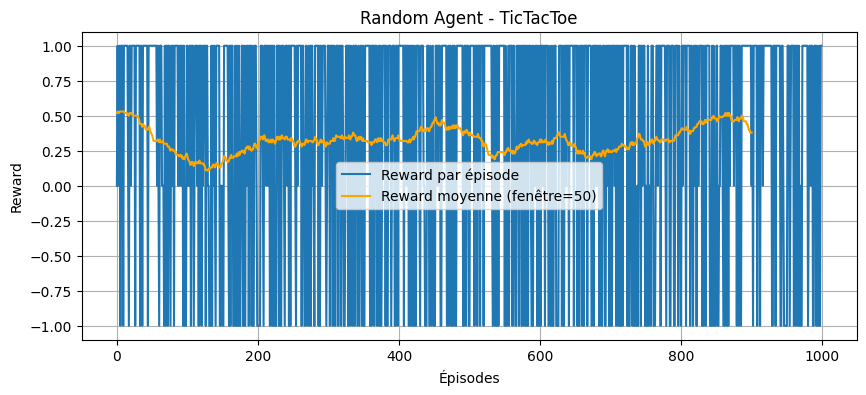


 Évaluation de la policy Random
Score moyen (ε=0): 0.390
Longueur moyenne : 4.24 steps
Temps moyen par action : 0.000 ms


In [20]:
def plot_rewards(rewards, title="Récompenses par épisode"):
    plt.figure(figsize=(10, 4))
    plt.plot(rewards, label='Reward par épisode')
    plt.plot(np.convolve(rewards, np.ones(100)/100, mode='valid'),
             label='Reward moyenne (fenêtre=50)', color='orange')
    plt.xlabel('Épisodes')
    plt.ylabel('Reward')
    plt.title(title)
    plt.grid()
    plt.legend()
    plt.show()

    
env = TicTacToe()
random_agent = RandomAgent()

print(" Entraînement de l'agent Random...")
rewards, lengths = train_agent(random_agent, env, episodes=1000)

print("\n Graphique des récompenses")
plot_rewards(rewards, title="Random Agent - TicTacToe")

print("\n Évaluation de la policy Random")
results_random = evaluate_agent(random_agent, env, episodes=100)
print(f"Score moyen (ε=0): {results_random['score_moyen']:.3f}")
print(f"Longueur moyenne : {results_random['longueur_moyenne']:.2f} steps")
print(f"Temps moyen par action : {results_random['temps_moyen_action']:.3f} ms")

TabularQLearning

In [ ]:
class TabularQLearningAgent:
    def __init__(self, alpha=0.1, gamma=0.99, epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.1):
        self.q_table = defaultdict(lambda: np.zeros(9))
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min

    def state_to_key(self, state):
        return ''.join(state)

    def select_action(self, state):
        key = self.state_to_key(state)
        if random.random() < self.epsilon:
            available = [i for i, v in enumerate(state) if v == ' ']
            return random.choice(available)
        q_values = self.q_table[key].copy()
        q_values = [q if state[i] == ' ' else -np.inf for i, q in enumerate(q_values)]
        return int(np.argmax(q_values))

    def learn(self, state, action, reward, next_state, done):
        key = self.state_to_key(state)
        next_key = self.state_to_key(next_state)

        max_next_q = max([self.q_table[next_key][i] for i, v in enumerate(next_state) if v == ' '], default=0)
        td_target = reward + self.gamma * max_next_q
        td_error = td_target - self.q_table[key][action]
        self.q_table[key][action] += self.alpha * td_error

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay


In [22]:
def train_agent(agent, env, episodes=1000):
    rewards = []
    lengths = []
    for ep in range(episodes):
        state = env.reset()
        done = False
        ep_reward = 0
        steps = 0
        while not done:
            action = agent.select_action(state)
            next_state, reward, done, info = env.step(action)
            agent.learn(state, action, reward, next_state, done)
            state = next_state
            ep_reward += reward
            steps += 1
        rewards.append(ep_reward)
        lengths.append(steps)
        if (ep + 1) % 100 == 0:
            print(f"Episode {ep+1}/{episodes} - Moyenne des 100 derniers rewards : {np.mean(rewards[-100:]):.3f}")
    return rewards, lengths

def evaluate_agent(agent, env, episodes=100):
    rewards = []
    lengths = []
    action_times = []
    for _ in range(episodes):
        state = env.reset()
        done = False
        ep_reward = 0
        steps = 0
        while not done:
            start = time.time()
            action = agent.select_action(state)
            action_times.append(time.time() - start)
            state, reward, done, info = env.step(action)
            ep_reward += reward
            steps += 1
        rewards.append(ep_reward)
        lengths.append(steps)
    return {
        "score_moyen": np.mean(rewards),
        "longueur_moyenne": np.mean(lengths),
        "temps_moyen_action": np.mean(action_times) * 1000  # en ms
    }


🔧 Entraînement de l'agent Random...
Episode 100/1000 - Moyenne des 100 derniers rewards : 0.280
Episode 200/1000 - Moyenne des 100 derniers rewards : 0.480
Episode 300/1000 - Moyenne des 100 derniers rewards : 0.470
Episode 400/1000 - Moyenne des 100 derniers rewards : 0.310
Episode 500/1000 - Moyenne des 100 derniers rewards : 0.170
Episode 600/1000 - Moyenne des 100 derniers rewards : 0.220
Episode 700/1000 - Moyenne des 100 derniers rewards : 0.330
Episode 800/1000 - Moyenne des 100 derniers rewards : 0.340
Episode 900/1000 - Moyenne des 100 derniers rewards : 0.320
Episode 1000/1000 - Moyenne des 100 derniers rewards : 0.420

📈 Graphique des récompenses


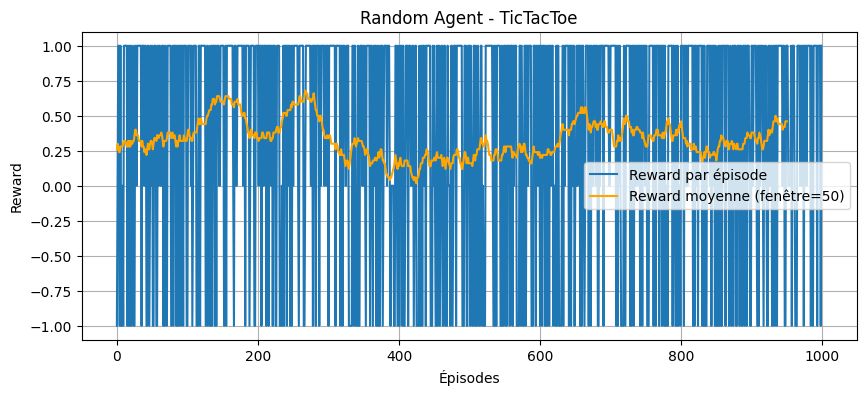


🧪 Évaluation de la policy Random
Score moyen (ε=0): 0.300
Longueur moyenne : 4.15 steps
Temps moyen par action : 0.000 ms


In [ ]:
def plot_rewards(rewards, title="Récompenses par épisode"):
    plt.figure(figsize=(10, 4))
    plt.plot(rewards, label='Reward par épisode')
    plt.plot(np.convolve(rewards, np.ones(50)/50, mode='valid'),
             label='Reward moyenne (fenêtre=50)', color='orange')
    plt.xlabel('Épisodes')
    plt.ylabel('Reward')
    plt.title(title)
    plt.grid()
    plt.legend()
    plt.show()


env = TicTacToe()
tabular_agent = TabularQLearningAgent()

print("🔧 Entraînement de l'agent Tabular Q-Learning...")
rewards_tabular, lengths_tabular = train_agent(tabular_agent, env, episodes=1000)

print("\n📈 Graphique des récompenses")
plot_rewards(rewards_tabular, title="Tabular Q-Learning - TicTacToe")

print("\n🧪 Évaluation de la policy Tabular Q-Learning")
results_tabular = evaluate_agent(tabular_agent, env, episodes=100)
print(f"Score moyen (ε=0): {results_tabular['score_moyen']:.3f}")
print(f"Longueur moyenne : {results_tabular['longueur_moyenne']:.2f} steps")
print(f"Temps moyen par action : {results_tabular['temps_moyen_action']:.3f} ms")



DeepQLearning

DoubleDeepQLearningWithExperienceReplay

DoubleDeepQLearningWithPrioritizedExperienceReplay


REINFORCE


REINFORCE with mean baseline

REINFORCE with Baseline Learned by a Critic

PPO A2C style

RandomRollout

Monte Carlo Tree Search (UCT)

Expert Apprentice

Joueur VS Bot

In [ ]:
def play_against_agent(agent, env):
    print("Bienvenue dans TicTacToe contre l'agent entraîné !")
    print("Vous êtes 'X', l'agent est 'O'")
    state = env.reset()
    human_turn = True

    while True:
        env.render()
        if human_turn:
            try:
                move = int(input("Entrez votre coup (0-8) : "))
                if state[move] != ' ':
                    print("Case occupée, rejouez.")
                    continue
            except (ValueError, IndexError):
                print("Entrée invalide. Entrez un nombre entre 0 et 8.")
                continue
            state[move] = 'X'
            if env.check_win('X'):
                env.render()
                print("🎉 Vous avez gagné !")
                break
            if ' ' not in state:
                env.render()
                print("🤝 Match nul.")
                break
            human_turn = False
        else:
            action = agent.select_action(state.copy())
            state[action] = 'O'
            print(f"L'agent joue en position {action}.")
            if env.check_win('O'):
                env.render()
                print("💻 L'agent a gagné.")
                break
            if ' ' not in state:
                env.render()
                print("🤝 Match nul.")
                break
            human_turn = True


In [ ]:
play_against_agent(tabular_agent, TicTacToe())
